In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolAlign
from scipy import spatial as sci_spatial
import torch
from tqdm.auto import tqdm
import seaborn as sns

ptable = Chem.GetPeriodicTable()

/u/dzhang5/miniforge3/envs/targetdiff_2_5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  

In [3]:
# import sys, os
# sys.path.insert(0, os.path.abspath('../'))

from utils.evaluation import eval_bond_length, scoring_func, similarity

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry> already registered; second conversion method ignored.


In [4]:
MODEL_NAME = 'TargetDiff'

# Load Data

In [ ]:
class Globals:
    reference_path = 'sampling_results/crossdocked_test_vina_docked.pt'
    cvae_path = 'sampling_results/CVAE_test_docked_sf1.5.pt'
    ar_path = 'sampling_results/ar_vina_docked.pt'
    pocket2mol_path = 'sampling_results/pocket2mol_vina_docked.pt'
    targetdiff_path = 'sampling_results/targetdiff_vina_docked.pt'
    our_path = 'outputs/base_model/eval_results/metrics_-1.pt'
    our_dpo_path = 'output/dpo_model/eval_results/metrics_-1.pt'

In [5]:
Globals.reference_results = torch.load(Globals.reference_path)
Globals.reference_results = [[v] for v in Globals.reference_results]
Globals.ar_results = torch.load(Globals.ar_path)
Globals.pocket2mol_results = torch.load(Globals.pocket2mol_path)
Globals.cvae_results = torch.load(Globals.cvae_path)
Globals.targetdiff_results = torch.load(Globals.targetdiff_path)


/tmp/ipykernel_2456053/4010728622.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Globals.reference_results = torch.load(Globals.reference_path)
/tmp/ipykernel_2456053/4

In [6]:
Globals.our_results = torch.load(Globals.our_path)['all_results']
Globals.our_dpo_results = torch.load(Globals.our_dpo_path)['all_results']

/tmp/ipykernel_2456053/2363643735.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Globals.our_results = torch.load(Globals.our_path)['all_results']
/tmp/ipykernel_245605

# Metrics Summary

In [7]:
def print_results(results, show_vina=True):
    qed = [r['chem_results']['qed'] for r in results]
    sa = [r['chem_results']['sa'] for r in results]
    mol_size = [r['mol'].GetNumAtoms() for r in results]
    print('Num results: %d' % len(results))
    if show_vina:
        vina_score_only = [x['vina']['score_only'][0]['affinity'] for x in results]
        vina_min = [x['vina']['minimize'][0]['affinity'] for x in results]
        # vina_dock = [r['vina']['dock'][0]['affinity'] for r in results]
        print('[Vina Score] Avg: %.2f | Med: %.2f' % (np.mean(vina_score_only), np.median(vina_score_only)))
        print('[Vina Min]   Avg: %.2f | Med: %.2f' % (np.mean(vina_min), np.median(vina_min)))
        # print('[Vina Dock]  Avg: %.4f | Med: %.4f' % (np.mean(vina_dock), np.median(vina_dock)))
        
    print('[QED]  Avg: %.4f | Med: %.4f' % (np.mean(qed), np.median(qed)))
    print('[SA]   Avg: %.4f | Med: %.4f' % (np.mean(sa), np.median(sa)))
    print('[Size] Avg: %.4f | Med: %.4f' % (np.mean(mol_size), np.median(mol_size)))

def compute_high_affinity(vina_ref, results):
    percentage_good = []
    num_docked = []
    qed_good, sa_good = [], []
    for i in range(100):
        score_ref = vina_ref[i]
        pocket_results = [r for r in results[i] if r['vina'] is not None]
        if len(pocket_results) < 50:
            continue
        num_docked.append(len(pocket_results))

        scores_gen = []
        for docked in pocket_results:
            aff = docked['vina']['dock'][0]['affinity']
            scores_gen.append(aff)
            if aff <= score_ref:
                qed_good.append(docked['chem_results']['qed'])
                sa_good.append(docked['chem_results']['sa'])
        scores_gen = np.array(scores_gen)
        percentage_good.append((scores_gen <= score_ref).mean())

    percentage_good = np.array(percentage_good)
    num_docked = np.array(num_docked)

    print('[HF%%]  Avg: %.2f%% | Med: %.2f%% ' % (np.mean(percentage_good)*100, np.median(percentage_good)*100))
    print('[HF-QED]  Avg: %.4f | Med: %.4f ' % (np.mean(qed_good)*100, np.median(qed_good)*100))
    print('[HF-SA]   Avg: %.4f | Med: %.4f ' % (np.mean(sa_good)*100, np.median(sa_good)*100))
    print('[Success%%] %.2f%% ' % (np.mean(percentage_good > 0)*100, ))

## Reference

In [8]:
flat_ref_docked = [r for pr in Globals.reference_results for r in pr]
print_results(flat_ref_docked)

Num results: 100
[Vina Score] Avg: -6.36 | Med: -6.46
[Vina Min]   Avg: -6.71 | Med: -6.49
[Vina Dock]  Avg: -7.4501 | Med: -7.2630
[QED]  Avg: 0.4760 | Med: 0.4676
[SA]   Avg: 0.7277 | Med: 0.7400
[Size] Avg: 22.7500 | Med: 21.5000


In [9]:
vina_ref = [r['vina']['dock'][0]['affinity'] for r in flat_ref_docked]


## AR

In [10]:
flat_ar_docked = [r for pr in Globals.ar_results for r in pr]
print_results(flat_ar_docked)
compute_high_affinity(vina_ref, Globals.ar_results)

Num results: 9295
[Vina Score] Avg: -5.75 | Med: -5.64
[Vina Min]   Avg: -6.18 | Med: -5.88
[Vina Dock]  Avg: -6.7459 | Med: -6.6220
[QED]  Avg: 0.5089 | Med: 0.4997
[SA]   Avg: 0.6366 | Med: 0.6300
[Size] Avg: 17.6815 | Med: 16.0000
[HF%]  Avg: 37.94% | Med: 31.00% 
[HF-QED]  Avg: 52.1360 | Med: 51.9444 
[HF-SA]   Avg: 59.7250 | Med: 59.0000 
[Success%] 91.58% 


## Pocket2Mol

In [11]:
flat_p2m_docked = [r for pr in Globals.pocket2mol_results for r in pr]
print_results(flat_p2m_docked)
compute_high_affinity(vina_ref, Globals.pocket2mol_results)

Num results: 9831
[Vina Score] Avg: -5.14 | Med: -4.70
[Vina Min]   Avg: -6.42 | Med: -5.82
[Vina Dock]  Avg: -7.1515 | Med: -6.7850
[QED]  Avg: 0.5729 | Med: 0.5770
[SA]   Avg: 0.7558 | Med: 0.7600
[Size] Avg: 17.7363 | Med: 15.0000
[HF%]  Avg: 48.36% | Med: 51.00% 
[HF-QED]  Avg: 56.5935 | Med: 57.5578 
[HF-SA]   Avg: 72.3812 | Med: 72.0000 
[Success%] 88.78% 


## TargetDiff

In [12]:
flat_targetdiff_docked = [r for pr in Globals.targetdiff_results for r in pr]
print_results(flat_targetdiff_docked)
compute_high_affinity(vina_ref, Globals.targetdiff_results)

Num results: 9036
[Vina Score] Avg: -5.47 | Med: -6.30
[Vina Min]   Avg: -6.64 | Med: -6.83
[Vina Dock]  Avg: -7.8018 | Med: -7.9080
[QED]  Avg: 0.4798 | Med: 0.4808
[SA]   Avg: 0.5846 | Med: 0.5800
[Size] Avg: 24.2371 | Med: 24.0000
[HF%]  Avg: 58.11% | Med: 59.09% 
[HF-QED]  Avg: 49.8408 | Med: 49.9754 
[HF-SA]   Avg: 56.3709 | Med: 56.0000 
[Success%] 98.99% 


# Our base model

In [15]:
flat_ours_docked = [r for pr in Globals.our_results for r in pr]
print_results(flat_ours_docked)
compute_high_affinity(vina_ref, Globals.our_results)


Num results: 8327
[Vina Score] Avg: -5.42 | Med: -5.83
[Vina Min]   Avg: -6.42 | Med: -6.41
[QED]  Avg: 0.4841 | Med: 0.4908
[SA]   Avg: 0.5960 | Med: 0.5800
[Size] Avg: 22.6139 | Med: 23.0000


KeyError: 'dock'

In [ ]:
flat_ours_docked

# Our DPO model

In [ ]:

flat_ours_dpo_docked = [r for pr in Globals.our_dpo_results for r in pr]
print_results(flat_ours_dpo_docked)
compute_high_affinity(vina_ref, Globals.our_dpo_results)

# Atom Distance

In [8]:
def get_all_atom_distance(results):
    atom_distance_list = []
    for pocket in results:
        for ligand in pocket:
            mol = ligand['mol']
            try:
                mol = Chem.RemoveAllHs(mol)
                pos = mol.GetConformers()[0].GetPositions()
                dist = sci_spatial.distance.pdist(pos, metric='euclidean')
                atom_distance_list += dist.tolist()
            except:
               continue
    return np.array(atom_distance_list)
        
Globals.reference_atom_dist = get_all_atom_distance(Globals.reference_results)
Globals.our_atom_dist = get_all_atom_distance(Globals.our_results)
Globals.ar_atom_dist = get_all_atom_distance(Globals.ar_results)
Globals.pocket2mol_atom_dist = get_all_atom_distance(Globals.pocket2mol_results)
Globals.cvae_atom_dist = get_all_atom_distance(Globals.cvae_results)
Globals.targetdiff_atom_dist = get_all_atom_distance(Globals.targetdiff_results)
Globals.ours_dpo_atom_dist = get_all_atom_distance(Globals.our_dpo_results)

In [9]:
def get_all_c_c_distance(results):
    c_c_distance_list = []
    for pocket in results:
        for ligand in pocket:
            mol = ligand['mol']
            try:
                mol = Chem.RemoveAllHs(mol)
                for bond_type, dist in eval_bond_length.bond_distance_from_mol(mol):
                    if bond_type[:2] == (6, 6):
                        c_c_distance_list.append(dist)
            except:
                continue
    return np.array(c_c_distance_list)

Globals.reference_c_c_dist = get_all_c_c_distance(Globals.reference_results)
Globals.our_c_c_dist = get_all_c_c_distance(Globals.our_results)
Globals.ar_c_c_dist = get_all_c_c_distance(Globals.ar_results)
Globals.pocket2mol_c_c_dist = get_all_c_c_distance(Globals.pocket2mol_results)
Globals.cvae_c_c_dist = get_all_c_c_distance(Globals.cvae_results)
Globals.targetdiff_c_c_dist = get_all_c_c_distance(Globals.targetdiff_results)
Globals.ours_dpo_c_c_dist = get_all_c_c_distance(Globals.our_dpo_results)

In [10]:
MODEL_NAME = 'MolFORM'

In [30]:
Globals.reference_c_c_dist

array([1.50036819, 1.35506206, 1.58570621, ..., 1.53696167, 1.55071635,
       1.56042476], shape=(1258,))

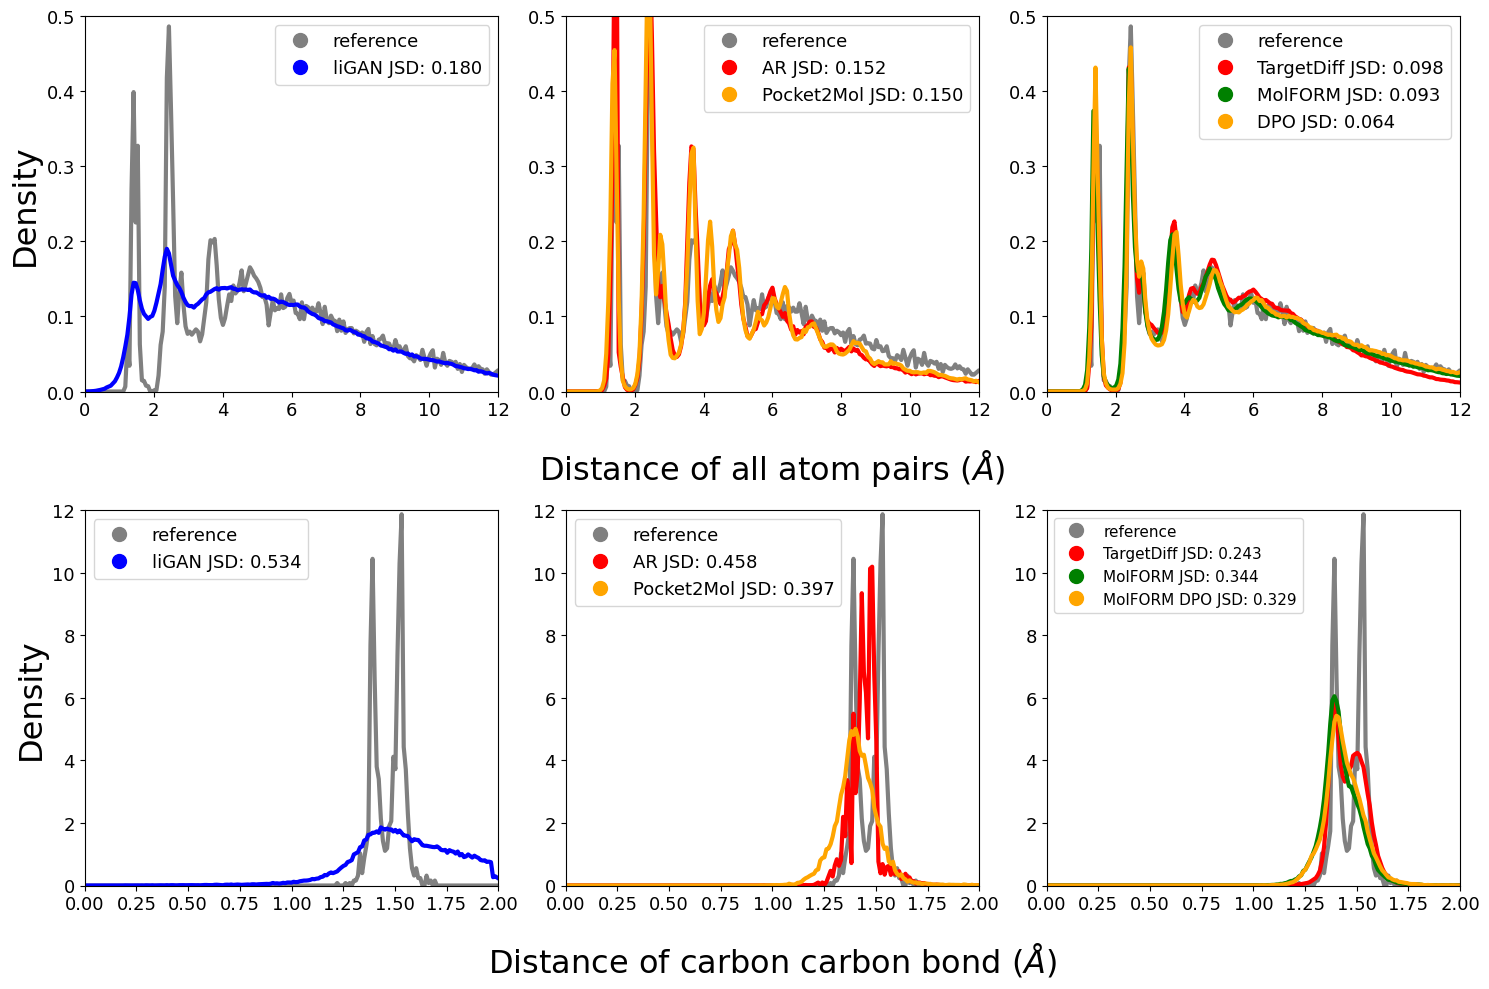

In [37]:
from matplotlib.lines import Line2D

def get_x_y(arr):
    y, bin_edges = np.histogram(arr, bins=BINS, density=True)
    x = 0.5 * (bin_edges[1:] + bin_edges[:-1])  # 取每个bin的中心作为x
    x = x.tolist()
    y = y.tolist()
    return x, y

plt.figure(figsize=(15, 10))

LW = 3
LABEL_FONTSIZE = 23
ALPHA = 1

BINS = np.linspace(0, 12, 200)
def _plot_other(plot_ylabel=False, plot_xlabel=False):
    if plot_ylabel:
        plt.ylabel('Density', fontsize=LABEL_FONTSIZE)
    if plot_xlabel:
        plt.xlabel('Distance of all atom pairs ($\AA$)', fontsize=LABEL_FONTSIZE, labelpad=20)
    plt.ylim(0, 0.5)
    plt.xlim(0, 12)
    # 加粗刻度标签
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    
reference_profile = eval_bond_length.get_distribution(Globals.reference_atom_dist, bins=BINS)
def _compute_jsd(atom_dist_list):
    profile = eval_bond_length.get_distribution(atom_dist_list, bins=BINS)
    return sci_spatial.distance.jensenshannon(reference_profile, profile)

ax = plt.subplot(2,3,1)
ligan_jsd = _compute_jsd(Globals.cvae_atom_dist)
x_ref,y_ref = get_x_y(Globals.reference_atom_dist)
x_ligan,y_ligan = get_x_y(Globals.cvae_atom_dist)
plt.plot(x_ref,y_ref,color='gray',lw=LW,alpha=ALPHA,label='reference')
plt.plot(x_ligan,y_ligan,color='blue',lw=LW,alpha=ALPHA,label=f'liGAN JSD: {ligan_jsd:.3f}')

handles = [
    Line2D([0], [0], color='gray', marker='o', linestyle='None', markersize=10, label='reference'),
    Line2D([0], [0], color='blue', marker='o', linestyle='None', markersize=10, label=f'liGAN JSD: {ligan_jsd:.3f}')
]
plt.legend(handles=handles, prop={'size': 13})

_plot_other(plot_ylabel=True)
ax = plt.subplot(2,3,2)
ar_jsd = _compute_jsd(Globals.ar_atom_dist)
p2m_jsd = _compute_jsd(Globals.pocket2mol_atom_dist)
x_ar,y_ar = get_x_y(Globals.ar_atom_dist)
x_p2m,y_p2m = get_x_y(Globals.pocket2mol_atom_dist) 
x_pocket2mol,y_pocket2mol = get_x_y(Globals.pocket2mol_atom_dist)
plt.plot(x_ref,y_ref,color='gray',lw=LW,alpha=ALPHA,label='reference')
plt.plot(x_ar,y_ar,color='red',lw=LW,alpha=ALPHA,label=f'AR JSD: {ar_jsd:.3f}')
plt.plot(x_p2m,y_p2m,color='orange',lw=LW,alpha=ALPHA,label=f'Pocket2Mol JSD: {p2m_jsd:.3f}')

handles = [
    Line2D([0], [0], color='gray', marker='o', linestyle='None', markersize=10, label='reference'),
    Line2D([0], [0], color='red', marker='o', linestyle='None', markersize=10, label=f'AR JSD: {ar_jsd:.3f}'),
    Line2D([0], [0], color='orange', marker='o', linestyle='None', markersize=10, label=f'Pocket2Mol JSD: {p2m_jsd:.3f}')
]
plt.legend(handles=handles, prop={'size': 13})

_plot_other(plot_xlabel=True)  # 在中间图显示 x 轴标签
ax = plt.subplot(2,3,3)
our_jsd = _compute_jsd(Globals.our_atom_dist)
td_jsd = _compute_jsd(Globals.targetdiff_atom_dist)
dpo_jsd = _compute_jsd(Globals.ours_dpo_atom_dist)
x_ref,y_ref = get_x_y(Globals.reference_atom_dist)
x_targetdiff,y_targetdiff = get_x_y(Globals.targetdiff_atom_dist)
x_ours,y_ours = get_x_y(Globals.our_atom_dist)
x_ours_dpo,y_ours_dpo = get_x_y(Globals.ours_dpo_atom_dist)
plt.plot(x_ref,y_ref,color='gray',lw=LW,alpha=ALPHA,label='reference')
plt.plot(x_targetdiff,y_targetdiff,color='red',lw=LW,alpha=ALPHA,label=f'TargetDiff JSD: {td_jsd:.3f}')
plt.plot(x_ours,y_ours,color='green',lw=LW,alpha=ALPHA,label=f'{MODEL_NAME} JSD: {our_jsd:.3f}')
plt.plot(x_ours_dpo,y_ours_dpo,color='orange',lw=LW,alpha=ALPHA,label=f'DPO JSD: {dpo_jsd:.3f}')

handles = [
    Line2D([0], [0], color='gray', marker='o', linestyle='None', markersize=10, label='reference'),
    Line2D([0], [0], color='red', marker='o', linestyle='None', markersize=10, label=f'TargetDiff JSD: {td_jsd:.3f}'),
    Line2D([0], [0], color='green', marker='o', linestyle='None', markersize=10, label=f'MolFORM JSD: {our_jsd:.3f}'),
    Line2D([0], [0], color='orange', marker='o', linestyle='None', markersize=10, label=f'DPO JSD: {dpo_jsd:.3f}')
]
plt.legend(handles=handles, prop={'size': 13})

_plot_other()
BINS = np.linspace(0, 2, 200)

def _plot_other(plot_ylabel=False, plot_xlabel=False):
    if plot_ylabel:
        plt.ylabel('Density', fontsize=LABEL_FONTSIZE)
    if plot_xlabel:
        plt.xlabel('Distance of carbon carbon bond ($\AA$)', fontsize=LABEL_FONTSIZE, labelpad=20)
    plt.ylim(0, 12)
    plt.xlim(0, 2)
    # 加粗刻度标签
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    
reference_profile = eval_bond_length.get_distribution(Globals.reference_c_c_dist, bins=BINS)
def _compute_jsd(atom_dist_list):
    profile = eval_bond_length.get_distribution(atom_dist_list, bins=BINS)
    return sci_spatial.distance.jensenshannon(reference_profile, profile)

ax = plt.subplot(2,3,4)
ligan_jsd = _compute_jsd(Globals.cvae_c_c_dist)
x_ref,y_ref = get_x_y(Globals.reference_c_c_dist)
x_cvae,y_cvae = get_x_y(Globals.cvae_c_c_dist)  
plt.plot(x_ref,y_ref,color='gray',lw=LW,alpha=ALPHA,label='reference')
plt.plot(x_cvae,y_cvae,color='blue',lw=LW,alpha=ALPHA,label=f'liGAN JSD: {ligan_jsd:.3f}')

handles = [
    Line2D([0], [0], color='gray', marker='o', linestyle='None', markersize=10, label='reference'),
    Line2D([0], [0], color='blue', marker='o', linestyle='None', markersize=10, label=f'liGAN JSD: {ligan_jsd:.3f}')
]
plt.legend(handles=handles, prop={'size': 13})

_plot_other(plot_ylabel=True)
ax = plt.subplot(2,3,5)
ar_jsd = _compute_jsd(Globals.ar_c_c_dist)
p2m_jsd = _compute_jsd(Globals.pocket2mol_c_c_dist)
x_ar,y_ar = get_x_y(Globals.ar_c_c_dist)
x_p2m,y_p2m = get_x_y(Globals.pocket2mol_c_c_dist)
plt.plot(x_ref,y_ref,color='gray',lw=LW,alpha=ALPHA,label='reference')
plt.plot(x_ar,y_ar,color='red',lw=LW,alpha=ALPHA,label=f'AR JSD: {ar_jsd:.3f}')
plt.plot(x_p2m,y_p2m,color='orange',lw=LW,alpha=ALPHA,label=f'Pocket2Mol JSD: {p2m_jsd:.3f}')

handles = [
    Line2D([0], [0], color='gray', marker='o', linestyle='None', markersize=10, label='reference'),
    Line2D([0], [0], color='red', marker='o', linestyle='None', markersize=10, label=f'AR JSD: {ar_jsd:.3f}'),
    Line2D([0], [0], color='orange', marker='o', linestyle='None', markersize=10, label=f'Pocket2Mol JSD: {p2m_jsd:.3f}')
]
plt.legend(handles=handles, prop={'size': 13})

_plot_other(plot_xlabel=True)  # 在中间图显示 x 轴标签
ax = plt.subplot(2,3,6)
targetdiff_jsd = _compute_jsd(Globals.targetdiff_c_c_dist)
ours_dpo_jsd = _compute_jsd(Globals.ours_dpo_c_c_dist)
our_jsd = _compute_jsd(Globals.our_c_c_dist)
x_targetdiff, y_targetdiff = get_x_y(Globals.targetdiff_c_c_dist)
x_ours, y_ours = get_x_y(Globals.our_c_c_dist)
x_ours_dpo, y_ours_dpo = get_x_y(Globals.ours_dpo_c_c_dist)
plt.plot(x_ref,y_ref,color='gray',lw=LW,alpha=ALPHA,label='reference')
plt.plot(x_targetdiff,y_targetdiff,color='red',lw=LW,alpha=ALPHA,label=f'TargetDiff JSD: {targetdiff_jsd:.3f}')
plt.plot(x_ours,y_ours,color='green',lw=LW,alpha=ALPHA,label=f'{MODEL_NAME} JSD: {our_jsd:.3f}')
plt.plot(x_ours_dpo,y_ours_dpo,color='orange',lw=LW,alpha=ALPHA,label=f'MolFORM DPO JSD: {ours_dpo_jsd:.3f}')

handles = [
    Line2D([0], [0], color='gray', marker='o', linestyle='None', markersize=10, label='reference'),
    Line2D([0], [0], color='red', marker='o', linestyle='None', markersize=10, label=f'TargetDiff JSD: {targetdiff_jsd:.3f}'),
    Line2D([0], [0], color='green', marker='o', linestyle='None', markersize=10, label=f'MolFORM JSD: {our_jsd:.3f}'),
    Line2D([0], [0], color='orange', marker='o', linestyle='None', markersize=10, label=f'MolFORM DPO JSD: {ours_dpo_jsd:.3f}')
]
plt.legend(handles=handles, prop={'size': 11})

_plot_other()

plt.tight_layout()
plt.show()

# Bond Distance

In [42]:
def get_bond_length_profile(results):
    bond_distances = []
    for pocket in results:
        for ligand in pocket:
            mol = ligand['mol']
            try:
                mol = Chem.RemoveAllHs(mol)
                bond_distances += eval_bond_length.bond_distance_from_mol(mol)
            except:
                continue
    return eval_bond_length.get_bond_length_profile(bond_distances)

Globals.reference_bond_length_profile = get_bond_length_profile(Globals.reference_results)
Globals.our_bond_length_profile = get_bond_length_profile(Globals.our_results)
Globals.ar_bond_length_profile = get_bond_length_profile(Globals.ar_results)
Globals.pocket2mol_bond_length_profile = get_bond_length_profile(Globals.pocket2mol_results)
Globals.cvae_bond_length_profile = get_bond_length_profile(Globals.cvae_results)
Globals.targetdiff_bond_length_profile = get_bond_length_profile(Globals.targetdiff_results)
Globals.ours_dpo_bond_length_profile = get_bond_length_profile(Globals.our_dpo_results)

In [43]:
REPORT_TYPE = (
    (6,6,1),
    (6,6,2),
    (6,6,4),
    (6,7,1),
    (6,7,2),
    (6,7,4),
    (6,8,1),
    (6,8,2),
    (6,8,4),
)

def _bond_type_str(bond_type) -> str:
    atom1, atom2, bond_category = bond_type
    return f'{atom1}-{atom2}|{bond_category}'

def eval_bond_length_profile(model_profile):
    metrics = {}

    for bond_type in REPORT_TYPE:
        metrics[f'JSD_{_bond_type_str(bond_type)}'] = sci_spatial.distance.jensenshannon(Globals.reference_bond_length_profile[bond_type],model_profile[bond_type])
    return metrics

eval_bond_length_profile(Globals.our_bond_length_profile)

{'JSD_6-6|1': np.float64(0.4907092268853753),
 'JSD_6-6|2': np.float64(0.5245898345112019),
 'JSD_6-6|4': np.float64(0.28129579056682547),
 'JSD_6-7|1': np.float64(0.4393791952737018),
 'JSD_6-7|2': np.float64(0.5856754324658389),
 'JSD_6-7|4': np.float64(0.3233117019056927),
 'JSD_6-8|1': np.float64(0.5027652665871206),
 'JSD_6-8|2': np.float64(0.4343803469426552),
 'JSD_6-8|4': np.float64(0.74431657657712)}

In [44]:
eval_bond_length_profile(Globals.ar_bond_length_profile)

{'JSD_6-6|1': np.float64(0.6090847252592992),
 'JSD_6-6|2': np.float64(0.6210207716132661),
 'JSD_6-6|4': np.float64(0.4504618126310079),
 'JSD_6-7|1': np.float64(0.4730538614136364),
 'JSD_6-7|2': np.float64(0.6356224885267152),
 'JSD_6-7|4': np.float64(0.5514678253305576),
 'JSD_6-8|1': np.float64(0.4917643812072614),
 'JSD_6-8|2': np.float64(0.5588741374756954),
 'JSD_6-8|4': np.float64(0.810528953192532)}

In [45]:
eval_bond_length_profile(Globals.pocket2mol_bond_length_profile)

{'JSD_6-6|1': np.float64(0.49593073995469816),
 'JSD_6-6|2': np.float64(0.5614630763511905),
 'JSD_6-6|4': np.float64(0.4158556788727053),
 'JSD_6-7|1': np.float64(0.42529234081136563),
 'JSD_6-7|2': np.float64(0.6285164082861111),
 'JSD_6-7|4': np.float64(0.4873078388654103),
 'JSD_6-8|1': np.float64(0.45402571782620554),
 'JSD_6-8|2': np.float64(0.5160702401133311),
 'JSD_6-8|4': np.float64(0.7828900804172967)}

In [46]:
eval_bond_length_profile(Globals.cvae_bond_length_profile)

{'JSD_6-6|1': np.float64(0.6012636163228565),
 'JSD_6-6|2': np.float64(0.664966333655714),
 'JSD_6-6|4': np.float64(0.49061703883050817),
 'JSD_6-7|1': np.float64(0.6337390838829144),
 'JSD_6-7|2': np.float64(0.749008177624315),
 'JSD_6-7|4': np.float64(0.6378309141539381),
 'JSD_6-8|1': np.float64(0.6558338746967367),
 'JSD_6-8|2': np.float64(0.6610208787840617),
 'JSD_6-8|4': np.float64(0.8325546111576978)}

# Rigid

In [47]:
import networkx as nx
from rdkit.Chem.rdchem import BondType
from copy import deepcopy
from collections import OrderedDict

In [63]:
class RotBondFragmentizer():
    def __init__(self, only_single_bond=True):
        self.type = 'RotBondFragmentizer'
        self.only_single_bond = only_single_bond

    # code adapt from Torsion Diffusion
    def get_bonds(self, mol):
        bonds = []
        G = nx.Graph()
        for i, atom in enumerate(mol.GetAtoms()):
            G.add_node(i)
        # nodes = set(G.nodes())
        for bond in mol.GetBonds():
            start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
            G.add_edge(start, end)
        for e in G.edges():
            G2 = copy.deepcopy(G)
            G2.remove_edge(*e)
            if nx.is_connected(G2): continue
            l = list(sorted(nx.connected_components(G2), key=len)[0])
            if len(l) < 2: continue
            # n0 = list(G2.neighbors(e[0]))
            # n1 = list(G2.neighbors(e[1]))
            if self.only_single_bond:
                bond_type = mol.GetBondBetweenAtoms(e[0], e[1]).GetBondType()
                if bond_type != BondType.SINGLE:
                    continue
            bonds.append((e[0], e[1]))
        return bonds

    def fragmentize(self, mol, dummyStart=1, bond_list=None):
        if bond_list is None:
            # get bonds need to be break
            bonds = self.get_bonds(mol)
        else:
            bonds = bond_list
        # whether the molecule can really be break
        if len(bonds) != 0:
            bond_ids = [mol.GetBondBetweenAtoms(x, y).GetIdx() for x, y in bonds]
            bond_ids = list(set(bond_ids))
            # break the bonds & set the dummy labels for the bonds
            dummyLabels = [(i + dummyStart, i + dummyStart) for i in range(len(bond_ids))]
            break_mol = Chem.FragmentOnBonds(mol, bond_ids, dummyLabels=dummyLabels)
            dummyEnd = dummyStart + len(dummyLabels) - 1
        else:
            break_mol = mol
            bond_ids = []
            dummyEnd = dummyStart - 1

        return break_mol, bond_ids, dummyEnd
    

def get_clean_mol(mol):
    rdmol = deepcopy(mol)
    for at in rdmol.GetAtoms():
        at.SetAtomMapNum(0)
        at.SetIsotope(0)
    Chem.RemoveStereochemistry(rdmol)
    return rdmol


def replace_atom_in_mol(ori_mol, src_atom, dst_atom):
    mol = deepcopy(ori_mol)
    m_mol = Chem.RWMol(mol)
    for atom in m_mol.GetAtoms():
        if atom.GetAtomicNum() == src_atom:
            atom_idx = atom.GetIdx()
            m_mol.ReplaceAtom(atom_idx, Chem.Atom(dst_atom))
    return m_mol.GetMol()


def ff_optimize(ori_mol, addHs=False, enable_torsion=False):
    mol = deepcopy(ori_mol)
    Chem.GetSymmSSSR(mol)
    if addHs:
        mol = Chem.AddHs(mol, addCoords=True)
    mp = AllChem.MMFFGetMoleculeProperties(mol, mmffVariant='MMFF94s')
    if mp is None:
        return (None, )

    # turn off angle-related terms
    mp.SetMMFFOopTerm(enable_torsion)
    mp.SetMMFFAngleTerm(True)
    mp.SetMMFFTorsionTerm(enable_torsion)

    # optimize unrelated to angles
    mp.SetMMFFStretchBendTerm(True)
    mp.SetMMFFBondTerm(True)
    mp.SetMMFFVdWTerm(True)
    mp.SetMMFFEleTerm(True)
    
#     try:
    ff = AllChem.MMFFGetMoleculeForceField(mol, mp)
    energy_before_ff = ff.CalcEnergy()
    ff.Minimize()
    energy_after_ff = ff.CalcEnergy()
    # print(f'Energy: {energy_before_ff} --> {energy_after_ff}')
    energy_change = energy_before_ff - energy_after_ff
    Chem.SanitizeMol(ori_mol)
    Chem.SanitizeMol(mol)
    rmsd = rdMolAlign.GetBestRMS(ori_mol, mol)
#     except:
#         return (None, )
    return energy_change, rmsd, mol


def frag_analysis_from_mol_list(input_mol_list):
    all_frags_dict = {}
    sg = RotBondFragmentizer()
    for mol in tqdm(input_mol_list):
        frags, _, _ = sg.fragmentize(mol)
        try:
            frags = [get_clean_mol(f) for f in Chem.GetMolFrags(frags, asMols=True)]
        except:
            continue

        for frag in frags:
            num_atoms = frag.GetNumAtoms() - Chem.MolToSmiles(frag).count('*')
            if 2 < num_atoms < 10:
                if num_atoms not in all_frags_dict:
                    all_frags_dict[num_atoms] = []

                mol = deepcopy(frag)
                mol_hs = replace_atom_in_mol(mol, src_atom=0, dst_atom=1)
                mol_hs = Chem.RemoveAllHs(mol_hs)
                all_frags_dict[num_atoms].append(mol_hs)
    
    all_frags_dict = OrderedDict(sorted(all_frags_dict.items()))
    all_rmsd_by_frag_size = {}
    all_energy_by_frag_size = {}
    for k, mol_list in all_frags_dict.items():
        n_fail = 0
        all_energy_diff, all_rmsd = [], []
        for mol in mol_list:
            ff_results = ff_optimize(mol, addHs=True, enable_torsion=False)
            if ff_results[0] is None:
                n_fail += 1
                continue
            energy_diff, rmsd, _, = ff_results
            all_energy_diff.append(energy_diff)
            all_rmsd.append(rmsd)
        print(f'Num of atoms: {k} ({n_fail} of {len(mol_list)} fail):   '
              f'\tEnergy {np.mean(all_energy_diff):.2f} / {np.median(all_energy_diff):.2f}' 
              f'\tRMSD   {np.mean(all_rmsd):.2f} / {np.median(all_rmsd):.2f}'
             )
        all_rmsd_by_frag_size[k] = all_rmsd
        all_energy_by_frag_size[k] = all_energy_diff
    return all_frags_dict, all_rmsd_by_frag_size, all_energy_by_frag_size

In [54]:
targetdiff_mols = [r['mol'] for pr in Globals.targetdiff_results for r in pr]
ar_mols = [r['mol'] for pr in Globals.ar_results for r in pr]
pocket2mol_mols = [r['mol'] for pr in Globals.pocket2mol_results for r in pr]
cvae_mols = [r['mol'] for pr in Globals.cvae_results for r in pr]
our_mols = [r['mol'] for pr in Globals.our_results for r in pr]
our_dpo_mols = [r['mol'] for pr in Globals.our_dpo_results for r in pr]


In [64]:
_, targetdiff_rigid_rmsd, targetdiff_rigid_energy = frag_analysis_from_mol_list(targetdiff_mols)
_, ar_rigid_rmsd, ar_rigid_energy = frag_analysis_from_mol_list(ar_mols)
_, pocket2mol_rigid_rmsd, pocket2mol_rigid_energy = frag_analysis_from_mol_list(pocket2mol_mols)
_, cvae_rigid_rmsd, cvae_rigid_energy = frag_analysis_from_mol_list(cvae_mols)
_, our_rigid_rmsd, our_rigid_energy = frag_analysis_from_mol_list(our_mols)
_, our_dpo_rigid_rmsd, our_dpo_rigid_energy = frag_analysis_from_mol_list(our_dpo_mols)


100%|██████████| 9036/9036 [00:36<00:00, 245.06it/s]


Num of atoms: 3 (0 of 6413 fail):   	Energy 38.45 / 7.31	RMSD   0.06 / 0.04
Num of atoms: 4 (2 of 1331 fail):   	Energy 77.99 / 30.57	RMSD   0.10 / 0.09
Num of atoms: 5 (12 of 894 fail):   	Energy 22.38 / 18.01	RMSD   0.12 / 0.11
Num of atoms: 6 (0 of 2871 fail):   	Energy 142.97 / 11.98	RMSD   0.12 / 0.09
Num of atoms: 7 (0 of 2360 fail):   	Energy 3700.58 / 28.92	RMSD   0.22 / 0.21
Num of atoms: 8 (1 of 1288 fail):   	Energy 8560.93 / 50.42	RMSD   0.32 / 0.30
Num of atoms: 9 (0 of 903 fail):   	Energy 4447.17 / 62.52	RMSD   0.38 / 0.34


100%|██████████| 9295/9295 [00:24<00:00, 378.82it/s]


Num of atoms: 3 (0 of 4874 fail):   	Energy 34.77 / 25.79	RMSD   0.09 / 0.07
Num of atoms: 4 (0 of 1769 fail):   	Energy 128.49 / 73.06	RMSD   0.17 / 0.15
Num of atoms: 5 (1 of 828 fail):   	Energy 41.54 / 23.89	RMSD   0.15 / 0.12
Num of atoms: 6 (0 of 2421 fail):   	Energy 46.71 / 30.42	RMSD   0.20 / 0.18
Num of atoms: 7 (0 of 2039 fail):   	Energy 79.66 / 56.47	RMSD   0.28 / 0.26
Num of atoms: 8 (0 of 1296 fail):   	Energy 115.36 / 76.50	RMSD   0.35 / 0.33
Num of atoms: 9 (0 of 852 fail):   	Energy 169.01 / 117.29	RMSD   0.39 / 0.36


100%|██████████| 9831/9831 [00:25<00:00, 386.09it/s]


Num of atoms: 3 (0 of 3626 fail):   	Energy 15.33 / 10.43	RMSD   0.06 / 0.06
Num of atoms: 4 (0 of 328 fail):   	Energy 38.03 / 33.93	RMSD   0.10 / 0.09
Num of atoms: 5 (0 of 762 fail):   	Energy 40.84 / 34.47	RMSD   0.13 / 0.12
Num of atoms: 6 (0 of 2138 fail):   	Energy 37.51 / 27.86	RMSD   0.12 / 0.10
Num of atoms: 7 (0 of 1673 fail):   	Energy 41.21 / 33.90	RMSD   0.20 / 0.20
Num of atoms: 8 (0 of 882 fail):   	Energy 51.09 / 42.97	RMSD   0.26 / 0.24
Num of atoms: 9 (0 of 708 fail):   	Energy 71.18 / 59.04	RMSD   0.31 / 0.29


100%|██████████| 9911/9911 [00:30<00:00, 320.22it/s]


Num of atoms: 3 (80 of 8969 fail):   	Energy 287.89 / 86.41	RMSD   0.22 / 0.19
Num of atoms: 4 (205 of 2610 fail):   	Energy 396.80 / 165.38	RMSD   0.31 / 0.28
Num of atoms: 5 (389 of 3466 fail):   	Energy 246.24 / 105.42	RMSD   0.26 / 0.21
Num of atoms: 6 (1 of 2828 fail):   	Energy 301.56 / 184.98	RMSD   0.34 / 0.32
Num of atoms: 7 (0 of 1829 fail):   	Energy 480.44 / 243.79	RMSD   0.40 / 0.37
Num of atoms: 8 (2 of 1195 fail):   	Energy 2114.69 / 333.09	RMSD   0.48 / 0.45
Num of atoms: 9 (1 of 867 fail):   	Energy 290701.86 / 544.48	RMSD   0.60 / 0.59


100%|██████████| 8327/8327 [00:31<00:00, 264.60it/s]


Num of atoms: 3 (143 of 4521 fail):   	Energy 1909.26 / 9.38	RMSD   0.08 / 0.06
Num of atoms: 4 (333 of 708 fail):   	Energy 190.56 / 31.72	RMSD   0.18 / 0.13
Num of atoms: 5 (23 of 1000 fail):   	Energy 37.44 / 22.90	RMSD   0.14 / 0.13
Num of atoms: 6 (0 of 3100 fail):   	Energy 292.42 / 23.55	RMSD   0.13 / 0.11
Num of atoms: 7 (1 of 2600 fail):   	Energy 114122314.05 / 50.95	RMSD   0.26 / 0.23
Num of atoms: 8 (0 of 1387 fail):   	Energy 55857057.29 / 84.59	RMSD   0.36 / 0.34
Num of atoms: 9 (1 of 794 fail):   	Energy 1982.00 / 92.76	RMSD   0.39 / 0.36


100%|██████████| 8039/8039 [00:30<00:00, 266.26it/s]


Num of atoms: 3 (5 of 2822 fail):   	Energy 55.91 / 9.36	RMSD   0.09 / 0.07
Num of atoms: 4 (69 of 432 fail):   	Energy 95.88 / 25.55	RMSD   0.18 / 0.14
Num of atoms: 5 (7 of 1273 fail):   	Energy 21.76 / 15.06	RMSD   0.11 / 0.09
Num of atoms: 6 (0 of 3842 fail):   	Energy 28.30 / 11.29	RMSD   0.11 / 0.08
Num of atoms: 7 (0 of 2543 fail):   	Energy 860.02 / 46.06	RMSD   0.23 / 0.22
Num of atoms: 8 (0 of 1257 fail):   	Energy 482.81 / 73.84	RMSD   0.34 / 0.33
Num of atoms: 9 (0 of 758 fail):   	Energy 164996.76 / 71.73	RMSD   0.36 / 0.34


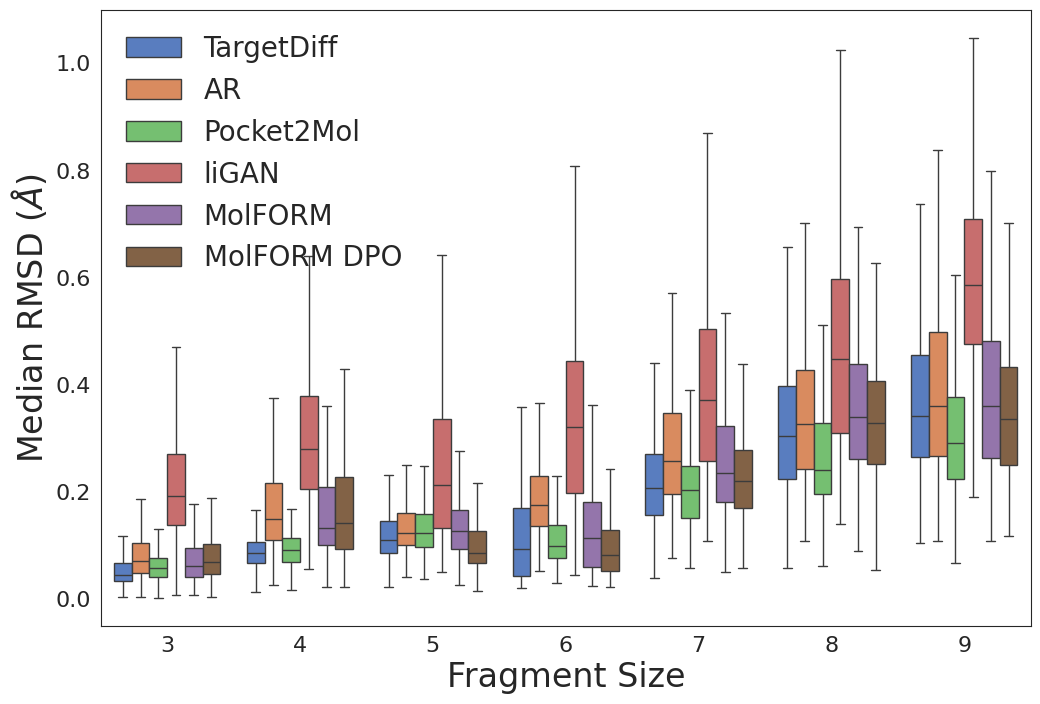

In [61]:
def construct_df(rigid_dict):
    df = []
    for k, all_v in rigid_dict.items():
        for v in all_v:
            df.append({'f_size': k, 'rmsd': v})
    return pd.DataFrame(df)

# sns.set(style="darkgrid")
sns.set_style("white")
sns.set_palette("muted")

tmp_1 = construct_df(targetdiff_rigid_rmsd)
tmp_1['model'] = 'TargetDiff'
tmp_2 = construct_df(ar_rigid_rmsd)
tmp_2['model'] = 'AR'
tmp_3 = construct_df(pocket2mol_rigid_rmsd)
tmp_3['model'] = 'Pocket2Mol'
tmp_4 = construct_df(cvae_rigid_rmsd)
tmp_4['model'] = 'liGAN'
tmp_5 = construct_df(our_rigid_rmsd)
tmp_5['model'] = MODEL_NAME
tmp_6 = construct_df(our_dpo_rigid_rmsd)
tmp_6['model'] = 'MolFORM DPO'

viz_df = pd.concat([tmp_1, tmp_2, tmp_3, tmp_4, tmp_5, tmp_6]).reset_index()
viz_df = viz_df.query('3<=f_size<=9')

LABEL_FONTSIZE = 24
TICK_FONTSIZE = 16
LEGEND_FONTSIZE = 20
plt.figure(figsize=(12, 8))
sns.boxplot(x='f_size', y='rmsd', hue='model', data=viz_df, hue_order=(tmp_1['model'].values[0], tmp_2['model'].values[0], tmp_3['model'].values[0], tmp_4['model'].values[0], tmp_5['model'].values[0], tmp_6['model'].values[0]), showfliers = False)
plt.xlabel('Fragment Size', fontsize=LABEL_FONTSIZE)
plt.ylabel('Median RMSD ($\AA{}$)', fontsize=LABEL_FONTSIZE)
plt.xticks(fontsize=TICK_FONTSIZE)
plt.yticks(fontsize=TICK_FONTSIZE)
plt.legend(frameon=False, fontsize=LEGEND_FONTSIZE)
# plt.savefig('output_figures/rigid_rmsd.pdf')
plt.show()

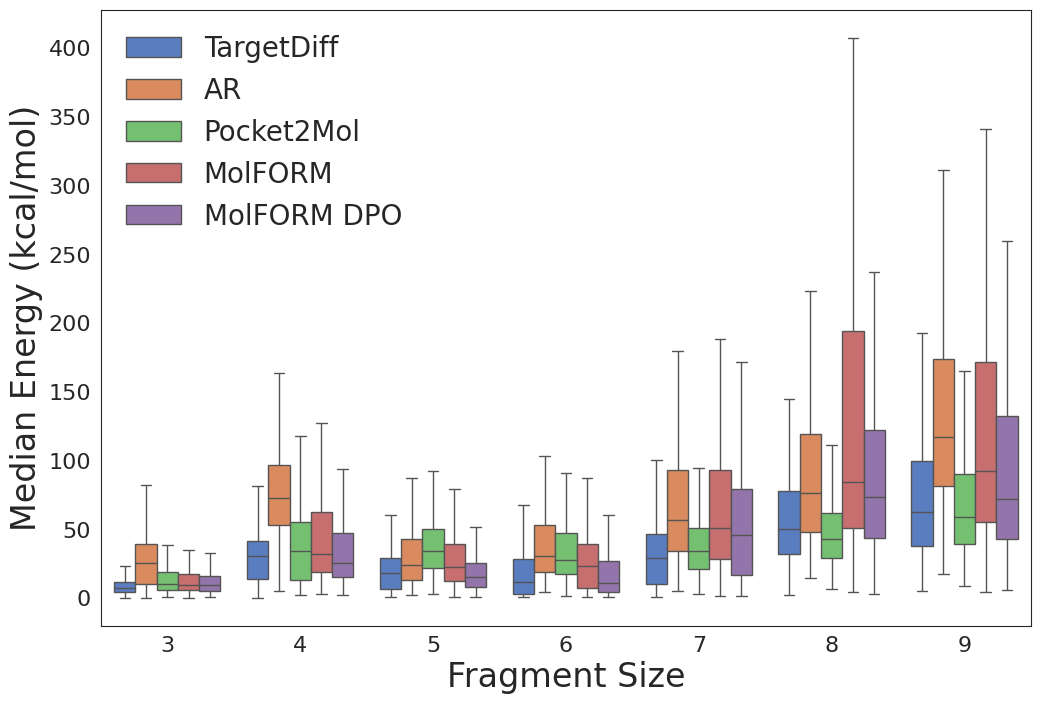

In [66]:
def construct_df(rigid_dict):
    df = []
    for k, all_v in rigid_dict.items():
        for v in all_v:
            df.append({'f_size': k, 'energy': v})
    return pd.DataFrame(df)

# sns.set(style="darkgrid")
sns.set_style("white")
sns.set_palette("muted")

tmp_1 = construct_df(targetdiff_rigid_energy)
tmp_1['model'] = 'TargetDiff'
tmp_2 = construct_df(ar_rigid_energy)
tmp_2['model'] = 'AR'
tmp_3 = construct_df(pocket2mol_rigid_energy)
tmp_3['model'] = 'Pocket2Mol'
tmp_4 = construct_df(cvae_rigid_energy)
tmp_4['model'] = 'liGAN'
tmp_5 = construct_df(our_rigid_energy)
tmp_5['model'] = MODEL_NAME
tmp_6 = construct_df(our_dpo_rigid_energy)
tmp_6['model'] = 'MolFORM DPO'

viz_df = pd.concat([tmp_1, tmp_2, tmp_3, tmp_5, tmp_6]).reset_index()
viz_df = viz_df.query('3<=f_size<=9')

LABEL_FONTSIZE = 24
TICK_FONTSIZE = 16
LEGEND_FONTSIZE = 20
plt.figure(figsize=(12, 8))
sns.boxplot(x='f_size', y='energy', hue='model', data=viz_df, hue_order=(tmp_1['model'].values[0], tmp_2['model'].values[0], tmp_3['model'].values[0], tmp_5['model'].values[0], tmp_6['model'].values[0]), showfliers = False)
plt.xlabel('Fragment Size', fontsize=LABEL_FONTSIZE)
plt.ylabel('Median Energy (kcal/mol)', fontsize=LABEL_FONTSIZE)
plt.xticks(fontsize=TICK_FONTSIZE)
plt.yticks(fontsize=TICK_FONTSIZE)
plt.legend(frameon=False, fontsize=LEGEND_FONTSIZE)
# plt.savefig('output_figures/rigid_rmsd.pdf')
plt.show()

# Vina Score

In [62]:
our_vina = np.array([np.median([v['vina']['dock'][0]['affinity'] for v in pocket]) for pocket in Globals.our_results])
ar_vina = np.array([np.median([v['vina']['dock'][0]['affinity'] for v in pocket]) if len(pocket) > 0 else 0. for pocket in Globals.ar_results])
pocket2mol_vina = np.array([np.median([v['vina']['dock'][0]['affinity'] for v in pocket]) for pocket in Globals.pocket2mol_results])

KeyError: 'dock'

In [41]:
all_vina = np.stack([our_vina, ar_vina, pocket2mol_vina], axis=0)
best_vina_idx = np.argmin(all_vina, axis=0)

In [ ]:
plt.figure(figsize=(25, 6), dpi=100)

ax = plt.subplot(1, 1, 1)
ax.set_prop_cycle('color', plt.cm.Set1.colors)
n_data = len(our_vina)
fig1_idx = np.argsort(our_vina)
ALPHA = 0.75
POINT_SIZE = 128
plt.scatter(np.arange(n_data), ar_vina[fig1_idx], label=f'AR (lowest in {np.mean(best_vina_idx==1)*100:.0f}%)', alpha=ALPHA, s=POINT_SIZE * 0.75)
plt.scatter(np.arange(n_data), pocket2mol_vina[fig1_idx], label=f'Pocket2Mol (lowest in {np.mean(best_vina_idx==2)*100:.0f}%)', alpha=ALPHA, s=POINT_SIZE * 0.75)
plt.scatter(np.arange(n_data), our_vina[fig1_idx], label=f'{MODEL_NAME} (lowest in {np.mean(best_vina_idx==0)*100:.0f}%)', alpha=ALPHA, s=POINT_SIZE)

# plt.xticks([])
plt.yticks(fontsize=16)
for i in range(n_data):
    plt.axvline(i, c='0.1', lw=0.2)
plt.xlim(-1, 100)
plt.ylim(-13, -1.5)
# plt.yticks([-10, -8, -6, -4, -2], [-10, -8, -6, -4, '$\geq$-2'], fontsize=25)
plt.yticks([-12, -10, -8, -6, -4, -2], [-12, -10, -8, -6, -4, -2], fontsize=25)
plt.ylabel('Median Vina Energy', fontsize=30)
plt.legend(fontsize=25, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.3), frameon=False)
plt.xticks(np.arange(0, 100, 10), [f'target {v}' for v in np.arange(0, 100, 10)], fontsize=25)

plt.tight_layout()
# plt.savefig('output_figures/binding.png')
plt.show()